In [24]:
import pandas as pd
import numpy as np
import missingno as msno
from math import nan

In [25]:
# directory = "C:\\Users\\devin\\Documents\\Dropbox\\Grad School\\3.Thesis_Model\\Method\\Tree\\"
HH = pd.read_csv('PZ16_HH.csv')
PER = pd.read_csv('PZ16_PER.csv')
TRIP = pd.read_csv('PZ16_TRIP.csv')

In [26]:
# Merge HH -> PER data, prepare TRIP by removing interregional and unnecessary fields
PER = PER.merge(HH[['hhld_num','dwell_type','income','n_person','n_vehicle']], left_on='hhld_num',right_on='hhld_num').drop(['no_work','n_tran_trip','waterzn_emp','waterzn_sch','expf','waterzn_emp.1'],axis=1)
PER = PER.rename(columns={"dwell_type":"hh_dwell_type","income":"hh_income","n_person":"hh_size","n_vehicle":"hh_n_vehs"})
PER = PER.drop(PER[PER.age<1].index)
TRIP = TRIP.drop(TRIP[TRIP.region_orig!=12].index)
TRIP = TRIP.drop(TRIP[TRIP.region_dest!=12].index)
TRIP = TRIP.drop(['purp_orig','purp_dest','trip_km','car_pool','region_orig','region_dest','waterzn_dest'],axis=1) # Removed drop of 'waterzn_orig' for DTA merge later

Pre NA drop: 45208
6630


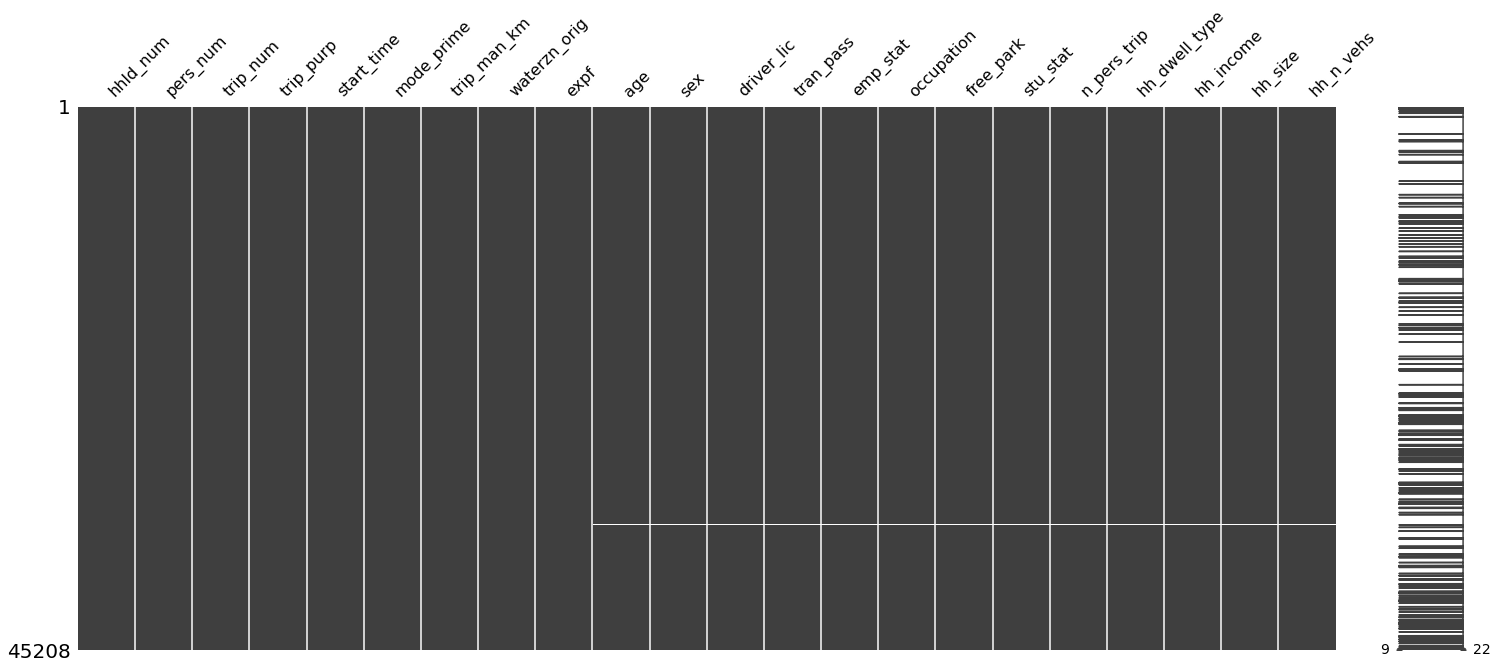

In [27]:
# Merge PER to TRIP on two columns (household and person). Drop NaN and count the number of dropped rows
data = pd.merge(TRIP,PER,how='left',left_on=['hhld_num','pers_num'],right_on=['hhld_num','pers_num']).reset_index(drop=True).sort_values(by=['hhld_num','pers_num'])
data['expf'] = data['expf'].round().astype(int)

# Analyze null values (cells)
print("Pre NA drop: "+str(data['mode_prime'].size))
df_na = data[data.isna().any(axis=1)]
na_count = data.isnull().sum().sum()
print(na_count)
msno.matrix(data)
# Drop any rows that incl. null values (NOTE: rows with "Unknown" entries (labelled "9") aren't removed in this step)
#data = data.dropna(axis=0, how='any')
#print("Post NA drop: "+str(data['mode_prime'].size))


In [28]:
# Bin, categorize, and group for analysis # QCUT sometimes requires duplicate quantiles be dropped (too many quantiles specified). Just lower the q= value.
data['age'] = pd.qcut(data['age'],q=10)
data['n_pers_trip'] = pd.qcut(data['n_pers_trip'],q=5)
data['hh_n_vehs'] = pd.cut(data['hh_n_vehs'],bins=[-0.01,0,1,2,99]) #bins = [1, 2, 3, 4] indicate (1,2], (2,3], (3,4]
data['hh_size'] = pd.cut(data['hh_size'],bins=[0.99,1,2,3,4,9]) # bins, but check histogram. If not enough ppl in 1 or 2 size HH, use q=4.
data['trip_man_km'] = pd.qcut(data['trip_man_km'],q=10)
# Replace times with peak(1)/off peak (0). Alt syntax: <dataset>.loc[<filter1> & (<filter2>),'<variable>']='<value>'
data['start_time'] = np.where((data['start_time'] <600), 0, data['start_time'])
data['start_time'] = np.where((data['start_time'] >555) & (data['start_time'] <935), 1, data['start_time'])
data['start_time'] = np.where((data['start_time'] >930) & (data['start_time'] <1500), 0, data['start_time'])
data['start_time'] = np.where((data['start_time'] >1455) & (data['start_time'] <1905), 1, data['start_time'])
data['start_time'] = np.where((data['start_time'] >1900), 0, data['start_time'])

In [29]:
data = data.replace(to_replace={
    'sex':{
        '9': nan},
    'driver_lic':
    {
        '9': nan
    },
    'tran_pass':
    {
        '9': nan
    },
    'emp_stat':
    {
        '9': nan
    },
    
    'start_time':{
        1:'Peak',0:'Off_peak'},
    'trip_purp':{
        1:'HBW',2:'HBW',3:'HBD',4:'Non-HB'},
     'mode_prime':{
         'B':'Transit','J':'Transit','D':'Drive','M':'Drive','P':'Passenger','T':'Passenger','U':'Passenger','C':'Bicycle','W':'Walk','G':'Other','S':'Other','O':'Other', '9':'Unknown'},
    #'mode_prime':{
        #'B':'Transit','J':'Transit','D':'Not_Transit','M':'Not_Transit','P':'Not_Transit','T':'Not_Transit','U':'Not_Transit','C':'Not_Transit','W':'Transit','G':'Not_Transit','S':'Not_Transit','O':'Not_Transit',9:None},
    'emp_stat':{
        'F':'Employed','P':'Employed','H':'Work_at_Home','J':'Work_at_Home','O':'Not_employed','9': nan},
    'occupation':{
        'G':'General_Office','P':'General_Office','M':'Manufacturing','S':'Retail&Service','O':'Not_employed','9': nan},
    'free_park':{
        'O':'Not Applicable','9':nan},
    'tran_pass':{
        'C':'Y','M':'Y','P':'Other_agency','O':'Other_agency','9': nan},
    'stu_stat':{
        'S':'Student','P':'Student','O':'Not_student','9':nan},
    'hh_dwell_type':{
        1:'House',2:'Apartment',3:'Townhouse',9:nan},
    'hh_income':{
        1:'<15k',2:'15k-39k',3:'40k-59k',4:'60k-99k',5:'100k-124k',6:'>124k',7:nan}
}, value=None)

In [30]:
data.occupation.value_counts()

General_Office    17110
Not_employed      16838
Retail&Service     6471
Manufacturing      4126
Name: occupation, dtype: int64

In [31]:
# Analyze null values (cells)
print("Pre NA drop: "+str(data['mode_prime'].size))
df_na = data[data.isna().any(axis=1)]
na_count = data.isnull().sum().sum()
print(na_count)

Pre NA drop: 45208
17486


In [32]:
data.to_csv('TripsWithMissing_AgeContinue.csv')

In [33]:
data.head()

,hhld_num,pers_num,trip_num,trip_purp,start_time,mode_prime,trip_man_km,waterzn_orig,expf,age,...,tran_pass,emp_stat,occupation,free_park,stu_stat,n_pers_trip,hh_dwell_type,hh_income,hh_size,hh_n_vehs
31273,100295,1,1,HBW,Peak,Drive,"(2.0, 3.0]",121187,40,"(41.0, 47.0]",...,N,Employed,Retail&Service,Y,Not_student,"(0.999, 2.0]",House,40k-59k,"(4.0, 9.0]","(2.0, 99.0]"
33545,100295,1,2,HBW,Peak,Drive,"(2.0, 3.0]",120069,40,"(41.0, 47.0]",...,N,Employed,Retail&Service,Y,Not_student,"(0.999, 2.0]",House,40k-59k,"(4.0, 9.0]","(2.0, 99.0]"
38854,100295,3,1,HBW,Off_peak,Drive,"(11.0, 16.0]",121187,40,"(10.999, 19.0]",...,Other_agency,Employed,Retail&Service,Y,Student,"(3.0, 4.0]",House,40k-59k,"(4.0, 9.0]","(2.0, 99.0]"
38855,100295,3,2,HBW,Peak,Drive,"(11.0, 16.0]",120025,40,"(10.999, 19.0]",...,Other_agency,Employed,Retail&Service,Y,Student,"(3.0, 4.0]",House,40k-59k,"(4.0, 9.0]","(2.0, 99.0]"
38856,100295,3,3,HBW,Peak,Drive,"(2.0, 3.0]",121187,40,"(10.999, 19.0]",...,Other_agency,Employed,Retail&Service,Y,Student,"(3.0, 4.0]",House,40k-59k,"(4.0, 9.0]","(2.0, 99.0]"


In [34]:
# Analyze null values (cells)
print("Pre NA drop: "+str(data['mode_prime'].size))
df_na = data[data.isna().any(axis=1)]
na_count = data.isnull().sum().sum()
print(na_count)

data = data.dropna(axis=0, how='any')
print("Post NA drop: "+str(data['mode_prime'].size))

Pre NA drop: 45208
17486
Post NA drop: 34608


In [35]:
data.to_csv('TripsWithoutMissing.csv')

# Visualizing Missing data in the dataset

In [53]:
df_md = pd.read_csv("TripsWithMissing.csv")

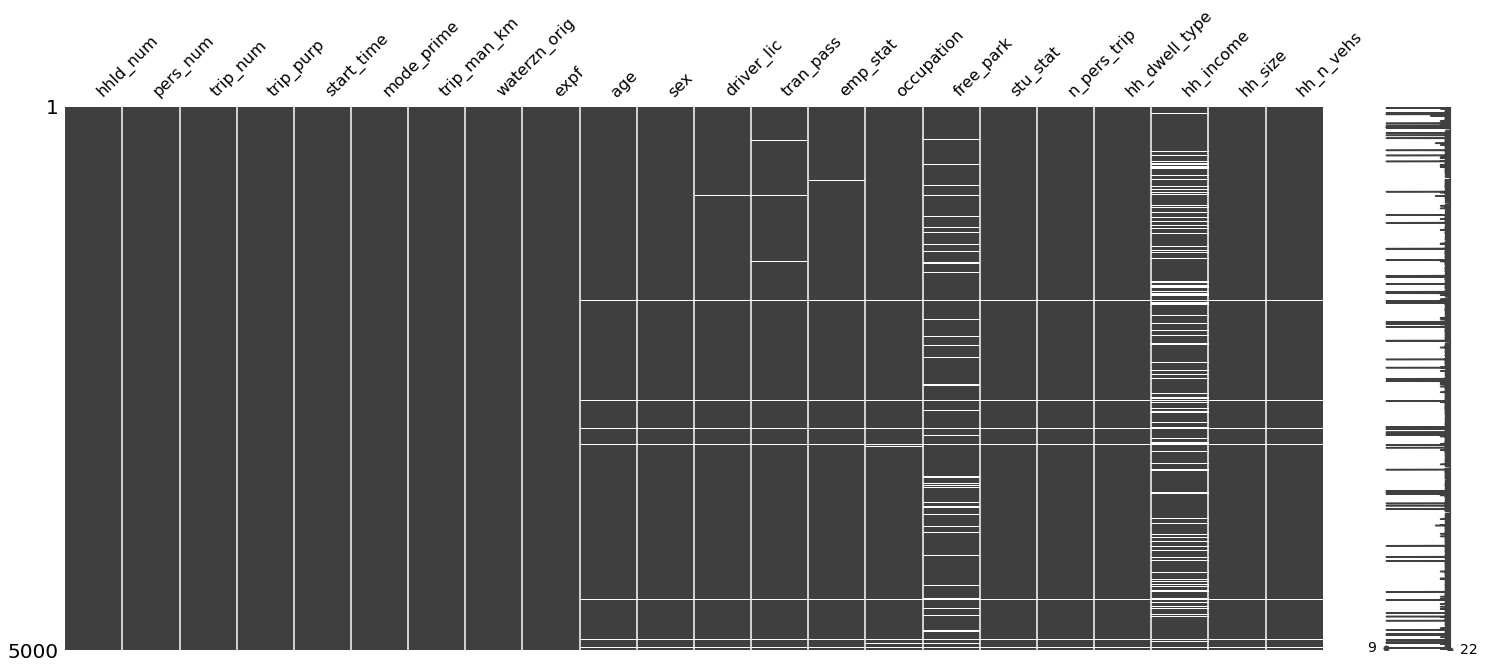

In [22]:
msno.matrix(data.sample(3400))

In [45]:
df_d = pd.read_csv("TripsWithoutMissing.csv")

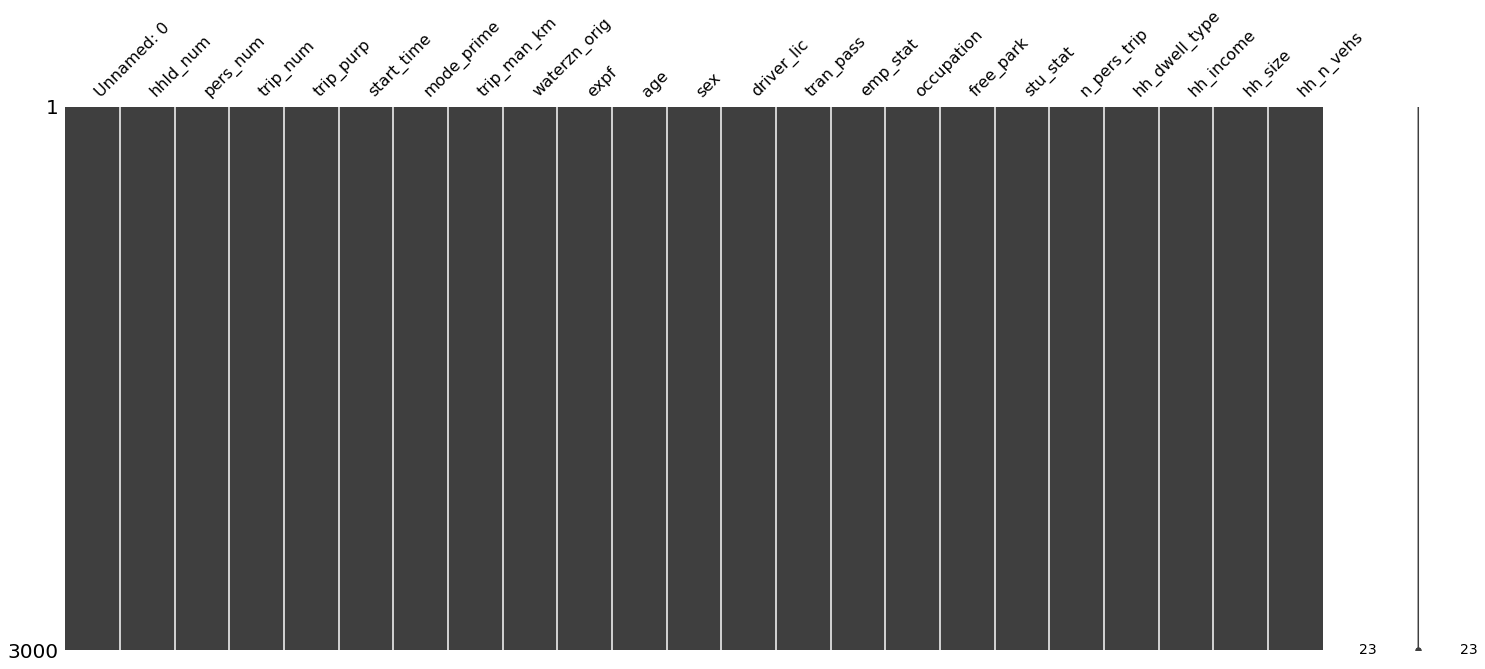

In [46]:
msno.matrix(df_d.sample(3000))